In [98]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pm.help()
#pm.reset()
#pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()

df_jo_cp.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 43 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         21055 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     21055 non-null  object         
 11  transfer_type               32092 non-nul

In [3]:
df_jo_cp.head()


,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,stat_cr,...,reco_last_update,updated_at_fe,Mes_created_at,cash_request_received_date,n_fees,n_backs,created_at_slot,created_at_slot_h,created_at_dow,good_user
0,3,0,NaN,47,1,2019-11-19 13:57:53.511561,NaT,1.0,NaN,canceled,...,NaT,NaT,2019-11,NaT,0,0,7,13-Mañana,1,False
1,4,0,NaN,99001309,0,2019-12-09 14:47:35.190714,NaT,100.0,NaN,money_back,...,NaT,NaT,2019-12,NaT,0,1,14,14-Tarde,0,False
2,5,0,NaN,804,1,2019-12-10 19:05:21.596873,NaT,100.0,NaN,rejected,...,NaT,NaT,2019-12,NaT,0,0,14,19-Tarde,1,False
3,6,0,NaN,812,1,2019-12-10 19:05:48.921042,NaT,100.0,NaN,direct_debit_rejected,...,2020-12-18 22:47:48.008850,NaT,2019-12,2019-12-11,0,0,14,19-Tarde,1,False
4,7,0,NaN,191,1,2019-12-10 19:13:35.825460,NaT,100.0,NaN,rejected,...,NaT,NaT,2019-12,NaT,0,0,14,19-Tarde,1,False


In [4]:
df_jo_cp.describe()

,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,to_receive_ini,...,from_date,to_date,updated_at,reco_creation,reco_last_update,updated_at_fe,cash_request_received_date,n_fees,n_backs,created_at_dow
count,32092.000000,32092.000000,21055.000000,3.209200e+04,32092.000000,32092,21055,32092.000000,21055.000000,24147,...,7765,7765,32092,7199,7199,21055,24147,32092.000000,32092.000000,32092.000000
mean,13822.470834,6985.532531,16319.072524,7.967657e+06,0.919824,2020-08-19 09:18:33.707913216,2020-09-21 14:41:09.166412544,83.516733,5.000237,2 days 01:11:32.034121915,...,2020-09-15 16:41:55.547103232,2020-10-06 04:14:39.339139072,2020-11-12 02:56:51.256851200,2020-10-01 02:38:48.797180928,2020-10-31 02:25:35.078318336,2020-10-18 23:08:24.179814400,2020-08-25 12:33:43.406634496,0.760719,2.015985,2.748847
min,3.000000,0.000000,1456.000000,3.400000e+01,0.000000,2019-11-19 13:57:53.511561,2020-05-29 14:27:50.787961,1.000000,5.000000,-1 days +02:01:55.968741,...,2020-05-27 22:00:00,2020-06-09 22:00:00,2019-12-11 09:46:59.779773,2020-03-19 22:10:48.090698,2020-03-31 16:05:16.427692,2020-10-13 14:25:00.740429,2019-12-10 00:00:00,0.000000,0.000000,0.000000
25%,7799.500000,0.000000,11745.500000,1.253700e+04,1.000000,2020-07-13 12:24:07.788202496,2020-08-29 00:02:05.202222080,50.000000,5.000000,0 days 16:03:52.736961500,...,2020-08-06 05:48:27.070000128,2020-09-04 22:00:00,2020-11-01 14:59:45.300140544,2020-08-19 22:25:54.124595968,2020-10-02 22:24:54.526753536,2020-10-13 14:25:08.557196288,2020-07-18 00:00:00,0.000000,0.000000,1.000000
50%,14115.000000,5132.500000,17166.000000,2.700500e+04,1.000000,2020-08-31 01:12:16.739052032,2020-10-03 08:12:48.966279936,100.000000,5.000000,1 days 10:45:33.008224,...,2020-09-25 22:00:00,2020-10-11 16:50:11.884000,2020-12-18 13:09:59.275440384,2020-10-14 22:35:00.223504896,2020-11-06 01:00:04.998823936,2020-10-13 14:25:16.478647040,2020-09-08 00:00:00,0.000000,1.000000,3.000000
75%,19936.250000,13166.250000,21797.000000,5.547150e+04,1.000000,2020-10-08 19:44:31.434317056,2020-10-22 11:40:32.909825536,100.000000,5.000000,2 days 13:35:58.365950,...,2020-10-27 11:00:00,2020-11-05 23:00:00,2020-12-18 13:12:02.949837056,2020-11-12 22:50:00.507954944,2020-12-08 22:06:54.053884928,2020-10-23 08:15:37.924329984,2020-10-15 00:00:00,1.000000,3.000000,4.000000
max,27010.000000,21193.000000,27010.000000,9.903044e+07,1.000000,2020-11-01 23:42:30.847066,2020-11-01 23:43:04.178637,200.000000,10.000000,60 days 17:02:04.753898,...,2021-01-02 22:00:00,2021-01-17 22:00:00,2021-02-12 04:15:27.796931,2021-02-11 23:08:48.764376,2021-02-12 04:15:27.744320,2021-02-10 09:59:06.999173,2020-11-27 00:00:00,15.000000,37.000000,6.000000
std,7416.395576,7070.009173,6656.149646,2.687968e+07,0.271569,NaN,NaN,25.900555,0.034458,2 days 05:14:18.090537826,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082516,2.530367,1.828468


In [72]:
df_transformado = df_jo_cp.copy()

# Convertir columnas datetime a timestamps
for col in df_transformado.select_dtypes(include=['datetime64']).columns:
    df_transformado[col] = df_transformado[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

# Convertir columnas slot en enteros
df_jo_cp['created_at_slot'] = pd.to_numeric(df_jo_cp['created_at_slot'], errors='coerce').astype('Int64')
df_jo_cp['created_at_dow'] = pd.to_numeric(df_jo_cp['created_at_dow'], errors='coerce').astype('Int64')

# Convertir columna good a 0 si False y 1 si es True
df_jo_cp['good_user'] = df_jo_cp['good_user'].astype(int)

# Filtrar las columnas numéricas (incluyendo las fechas transformadas)
df_numericas = df_transformado.select_dtypes(include=['float64', 'int64'])



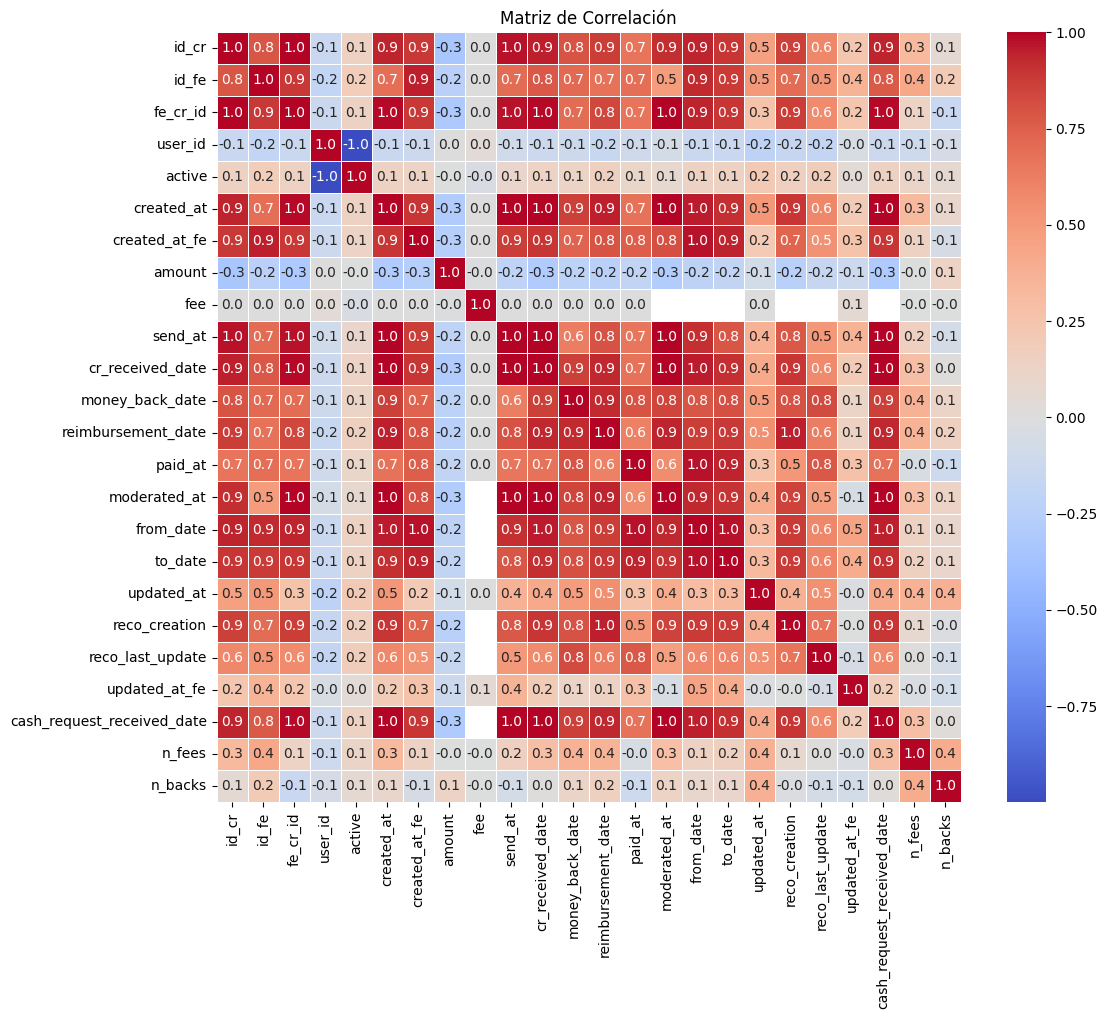

In [73]:
# Calcular la matriz de correlación
matriz_correlacion = df_numericas.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

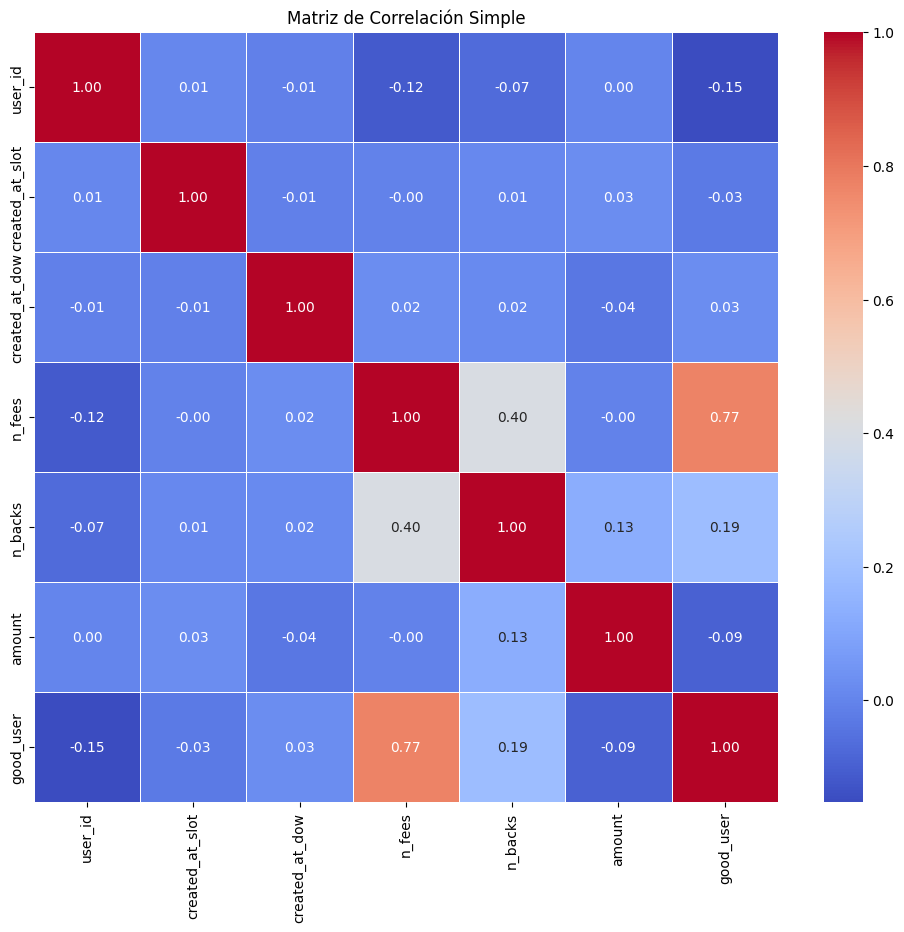

In [74]:
# Lista de columnas que deseas seleccionar
columnas_deseadas = ['user_id', 'created_at_slot', 'created_at_dow' , 'n_fees', 'n_backs', 'amount', 'good_user']

# Crear un nuevo DataFrame con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [75]:
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

In [99]:
# Aplicación PCA a ver qué pasa con estos datos

# Separación correcta de X e y
X = df_simpl.drop(columns=['good_user', 'user_id'])  # Elimina la columna 'good_user' por nombre y tb la de user_id
y = df_simpl['good_user']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Estandarización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar las primeras filas estandarizadas
pd.DataFrame(X_scaled, columns=feature_names).head()


,created_at_slot,created_at_dow,n_fees,n_backs,amount
0,-0.995137,-0.956470,-0.702743,-0.796729,-3.185956
1,0.314786,-1.503384,-0.702743,-0.401523,0.636416
2,0.314786,-0.956470,-0.702743,-0.796729,0.636416
3,0.314786,-0.956470,-0.702743,-0.796729,0.636416
4,0.314786,-0.956470,-0.702743,-0.796729,0.636416


In [77]:
# Calcular la matriz de covarianza
cov_matrix = np.cov(X_scaled.T)

# Calcular los valores propios y los vectores propios
eig_values, eig_vectors = np.linalg.eig(cov_matrix)

# Mostrar los valores propios y los vectores propios
print("Valores propios:", eig_values)
print("\nVectores propios:\n", eig_vectors)

Valores propios: [1.42502774 0.57378639 1.05689614 0.95681938 0.98762615]

Vectores propios:
 [[-0.02776247  0.01676405  0.45634697  0.26973874  0.84731143]
 [-0.04707794  0.01061778 -0.58393126 -0.62767554  0.51256086]
 [-0.67420143  0.67270627 -0.19287157  0.23595593 -0.0066385 ]
 [-0.70732306 -0.70630524  0.01818504  0.00688465 -0.0211873 ]
 [-0.20532764  0.21955731  0.6428387  -0.69104401 -0.13730161]]


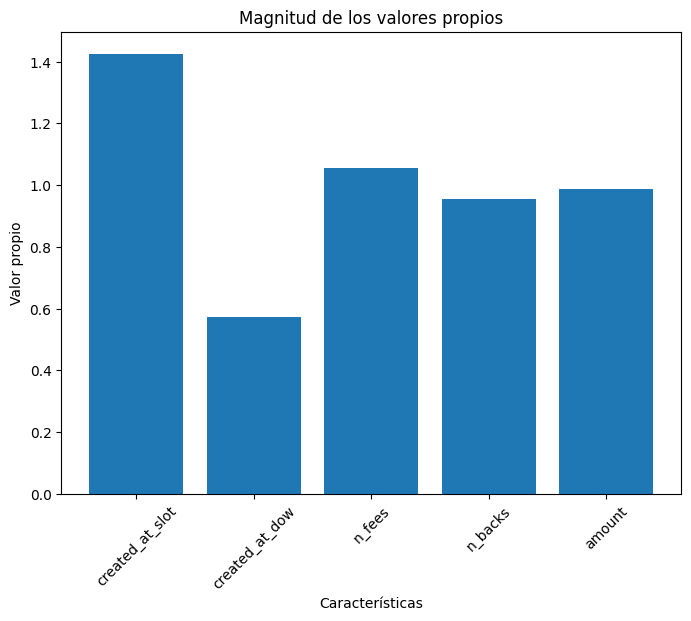

In [78]:
# Visualización de los valores propios (magnitud de varianza)
plt.figure(figsize=(8,6))
plt.bar(range(len(eig_values)), eig_values, tick_label=feature_names)
plt.xlabel('Características')
plt.ylabel('Valor propio')
plt.title('Magnitud de los valores propios')
plt.xticks(rotation=45)
plt.show()

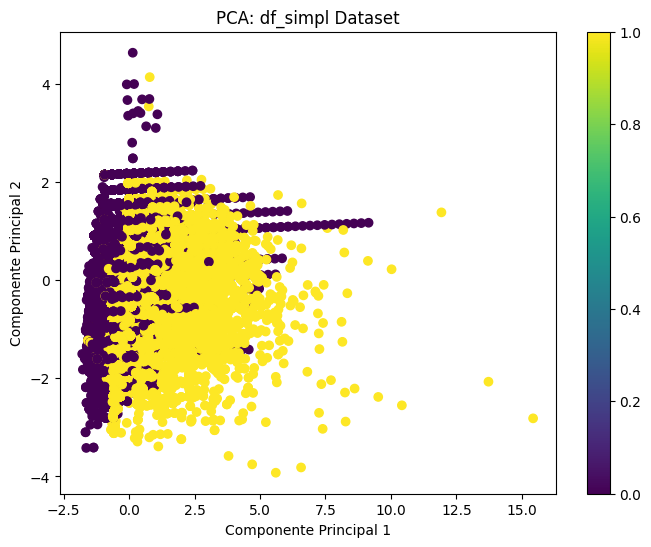

In [79]:
# Aplicar PCA
n_components = len(eig_values)
pca = PCA(n_components)
X_pca = pca.fit_transform(X_scaled)

# Visualizar los resultados de PCA
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA: df_simpl Dataset')
plt.colorbar(label='')
plt.show()

In [80]:
# Mostrar la varianza explicada por cada componente
print(f"Varianza explicada por los primeros dos componentes: {sum(pca.explained_variance_ratio_[0:2])}")

Varianza explicada por los primeros dos componentes: 0.4963693086839005


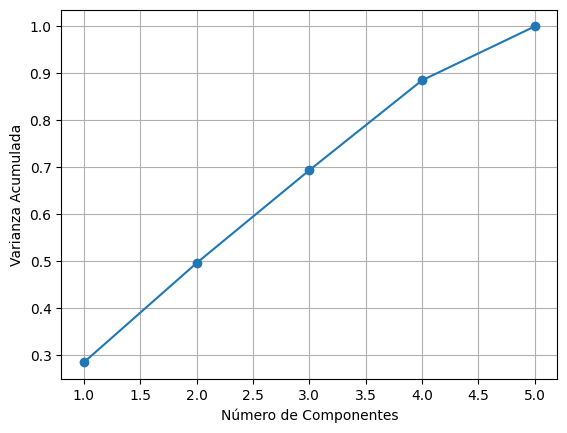

In [81]:
# Verificar cuántas componentes se necesitan para un buen nivel de varianza explicada

pca = PCA()
pca.fit(X_scaled)
explained_variance = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.show()


Necesitamos 4 componentes para poder explicar el 90% (casi) de los datos. 

## REGRESIÓN LOGÍSTICA 

In [100]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl.drop(columns=['good_user', 'user_id'])  # Elimina la columna 'good_user' por nombre
y = df_simpl['good_user']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

In [132]:
X.shape

(6419, 10)

In [102]:
# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [108]:
# Crea el clasificador de regresión logística
clf = LogisticRegression(solver="liblinear")

In [109]:
# Entrena el clasificador
clf.fit(X_train, y_train)


LogisticRegression(solver='liblinear')

In [112]:
# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Muestra las primeras 10 predicciones
predicciones[:10]

array([0, 0, 0, 1, 0, 0, 1, 1, 0, 0])

In [114]:
# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
predicciones_probabilidades[:10]

array([[9.98185754e-01, 1.81424565e-03],
       [9.92941966e-01, 7.05803394e-03],
       [9.95384526e-01, 4.61547422e-03],
       [2.27852316e-08, 9.99999977e-01],
       [9.98996014e-01, 1.00398600e-03],
       [9.91202670e-01, 8.79732991e-03],
       [3.52816912e-03, 9.96471831e-01],
       [1.05621666e-03, 9.98943783e-01],
       [9.94310623e-01, 5.68937728e-03],
       [9.99057676e-01, 9.42323854e-04]])

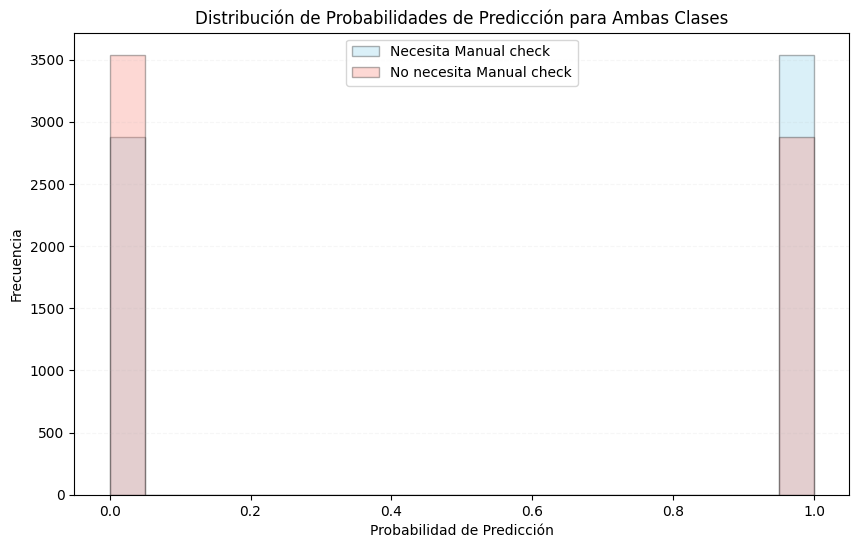

In [115]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [116]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

In [117]:
# Reinicia el índice y crea una copia de los datos de prueba
X = X_test.reset_index().copy()
X["good_user"] = y_test.tolist()

In [118]:
# Combina los datos de prueba con las probabilidades de predicción
X["prediccion"] = predicciones
X = pd.concat([X, probs_df], axis=1)

In [120]:
# Muestra las primeras 20 filas de comparación
X[["good_user", "prediccion", 0, 1]].head(20)

,good_user,prediccion,0,1
0,0,0,9.981858e-01,0.001814
1,0,0,9.929420e-01,0.007058
2,0,0,9.953845e-01,0.004615
3,1,1,2.278523e-08,1.000000
4,0,0,9.989960e-01,0.001004
5,0,0,9.912027e-01,0.008797
6,1,1,3.528169e-03,0.996472
7,1,1,1.056217e-03,0.998944
8,0,0,9.943106e-01,0.005689
9,0,0,9.990577e-01,0.000942


Text(70.5815972222222, 0.5, 'Realidad')

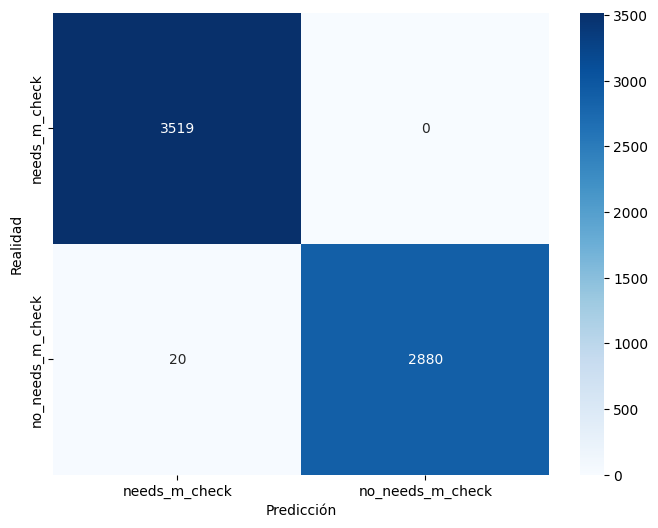

In [131]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['needs_m_check', 'no_needs_m_check'] # 0 para los que SI necesitan manual check porque NO son good_user (y un 1 para los que NO necesitan manual check porque son good_user y por lo tanto tienen un 1)

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")